<a href="https://colab.research.google.com/github/hajmamed/BigDataHws/blob/main/Spark_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 54.6 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data

In [3]:
import pyspark
from pyspark.sql import SparkSession
filePath = '/content/drive/MyDrive/BigData/data.csv'

spark = SparkSession.builder.appName('BigDataFinal').getOrCreate()
sc=spark.sparkContext
df=spark.read.format("csv").option("header","true").load(filePath)
df.printSchema()
df.select("*").show(5)

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: string (nullable = true)
 |-- Lon: string (nullable = true)
 |-- Base: string (nullable = true)

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|9/1/2014 0:01:00|40.2201|-74.0021|B02512|
|9/1/2014 0:01:00|  40.75|-74.0027|B02512|
|9/1/2014 0:03:00|40.7559|-73.9864|B02512|
|9/1/2014 0:06:00| 40.745|-73.9889|B02512|
|9/1/2014 0:11:00|40.8145|-73.9444|B02512|
+----------------+-------+--------+------+
only showing top 5 rows



In [15]:
df = df.withColumn("Lat",df.Lat.cast('double'))\
        .withColumn("Lon",df.Lon.cast('double'))
df.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)



# Data Shuffling

In [17]:
from pyspark.sql.functions import rand

df = df.orderBy(rand())
df.show(5)

+------------------+-------+--------+------+
|         Date/Time|    Lat|     Lon|  Base|
+------------------+-------+--------+------+
|6/18/2014 19:03:00| 40.752|-73.9733|B02682|
| 4/19/2014 5:15:00|40.6971|-73.9883|B02617|
| 5/15/2014 6:22:00| 40.736|-73.9978|B02598|
|9/30/2014 20:31:00|40.7815|-73.9758|B02764|
|4/26/2014 15:51:00|  40.72|-74.0051|B02598|
+------------------+-------+--------+------+
only showing top 5 rows



# Select 20% data to train

In [18]:
train_data = df.sample(0.2)
train_data.show(5)

+------------------+-------+--------+------+
|         Date/Time|    Lat|     Lon|  Base|
+------------------+-------+--------+------+
|9/19/2014 23:31:00|40.6344|-73.9651|B02617|
| 5/1/2014 19:30:00|40.6449|-73.7822|B02682|
| 8/7/2014 23:02:00|40.6869|-73.9769|B02598|
|5/30/2014 19:24:00|40.7461| -73.977|B02598|
|4/11/2014 18:24:00|40.7471|-74.0014|B02598|
+------------------+-------+--------+------+
only showing top 5 rows



In [11]:
train_data.count()

907338

# Create feature vector from data to train

In [32]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import *
from pyspark.ml.feature import VectorAssembler


vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["Lat","Lon"])
transformed = vecAssembler.transform(train_data)
transformed.show(5)

+------------------+-------+--------+------+------------------+
|         Date/Time|    Lat|     Lon|  Base|          features|
+------------------+-------+--------+------+------------------+
| 7/12/2014 8:56:00|40.7254|-73.9939|B02598|[40.7254,-73.9939]|
|5/27/2014 21:17:00|40.7566|-73.9754|B02617|[40.7566,-73.9754]|
|7/20/2014 12:55:00|40.7224|-73.9594|B02682|[40.7224,-73.9594]|
| 7/10/2014 6:33:00|40.7804| -73.976|B02598| [40.7804,-73.976]|
|7/23/2014 11:57:00|40.6447|-73.7823|B02598|[40.6447,-73.7823]|
+------------------+-------+--------+------+------------------+
only showing top 5 rows



# Start Clustering with Kmeans for k=2 to 10

We know something about this data and guess the best number of clusters should be 2-10 So we test all these Ks and compare their results with silhoutte factor and test costs factor

In [35]:
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import *


costs = []
silhouette = []
evaluator = ClusteringEvaluator()
for k in range(2, 10):
    print("Process k=" + str(k) + " clustering")
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(transformed)
    predictions = model.transform(transformed)
    sil_factor = evaluator.evaluate(predictions)
    silhouette.append(sil_factor)
    k_cost = model.summary.trainingCost
    costs.append(k_cost)
    print("Clustering by k=" + str(k) + " with silhouette factor=" + str(sil_factor) + " and cost=" + str(k_cost))


Process k=2 clustering
Clustering by k=2 with silhouette factor=0.8616307217384176 and cost=2731.6396847668775
Process k=3 clustering
Clustering by k=3 with silhouette factor=0.8413696019318339 and cost=2469.38958064692
Process k=4 clustering
Clustering by k=4 with silhouette factor=0.6013035204318685 and cost=1750.1350190376968
Process k=5 clustering
Clustering by k=5 with silhouette factor=0.4499846270924566 and cost=1487.8867326798756
Process k=6 clustering
Clustering by k=6 with silhouette factor=0.5671112977313193 and cost=1089.760016910044
Process k=7 clustering
Clustering by k=7 with silhouette factor=0.3474600675989086 and cost=1192.1646550539253
Process k=8 clustering
Clustering by k=8 with silhouette factor=0.41686124221756865 and cost=1297.4294939730048
Process k=9 clustering
Clustering by k=9 with silhouette factor=0.5328384603011753 and cost=844.8395120748996


# Plot Elbow

to fugire our best number of clusters we plot and visualize them and find the elbow point

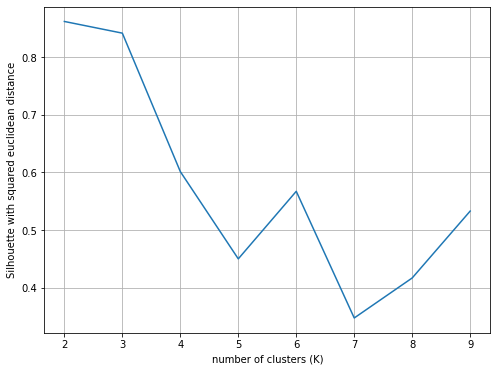

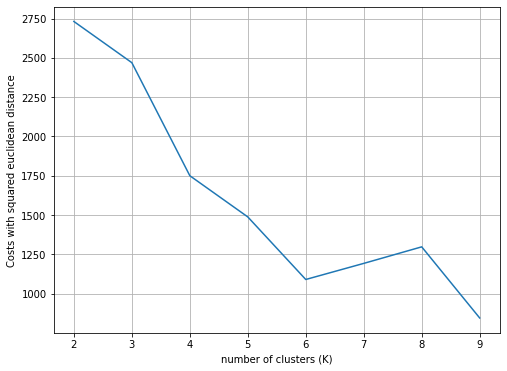

In [36]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([2, 3, 4, 5, 6, 7, 8, 9], silhouette)
ax.set_xlabel('number of clusters (K)')
ax.set_ylabel('Silhouette with squared euclidean distance')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()
plt.show()



fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([2, 3, 4, 5, 6, 7, 8, 9], costs)
ax.set_xlabel('number of clusters (K)')
ax.set_ylabel('Costs with squared euclidean distance')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()
plt.show()

# K=3 is the best

we find k=3 best cluster numbers so we create our model base on k=3

In [37]:
k = 3
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(transformed)
predictions = model.transform(transformed)
centroids_k = model.clusterCenters()
print(centroids_k)

[array([ 40.74039495, -73.98481099]), array([ 40.8739326 , -73.63632237]), array([ 40.71393048, -73.83196384])]


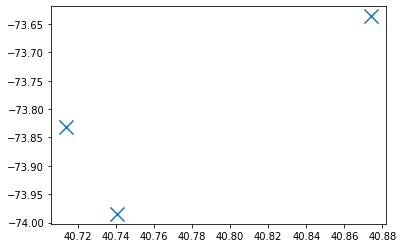

In [41]:
import pandas as pd
clocation_k = pd.DataFrame(centroids_k, columns=['Latitude', 'Longitude'])
plt.scatter(clocation_k['Latitude'], clocation_k['Longitude'], marker="x", s=200)
plt.show()

In [48]:
cnt_df = predictions.groupBy("prediction").count()
cnt_df.show()


+----------+------+
|prediction| count|
+----------+------+
|         1|  4442|
|         2| 59593|
|         0|841273|
+----------+------+



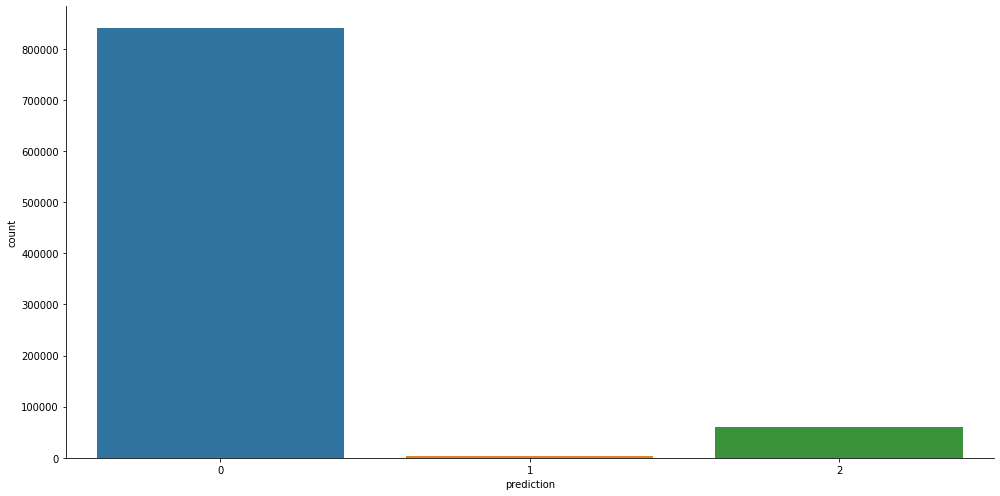

In [60]:
import seaborn as sb

clusters =predictions.toPandas()
sb.catplot(data=clusters, x="prediction", kind="count", height=7, aspect=2)
plt.show()


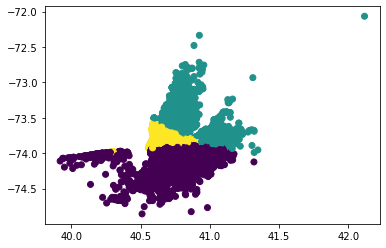

In [61]:
plt.scatter(clusters['Lat'], clusters['Lon'], c=clusters['prediction'], cmap='viridis')
plt.show()

# Save the model

In [62]:
import os, tempfile

model_path = "/content/drive/MyDrive/BigData/finalized_model"
model.save(model_path)